# Visualization + Results for Linear Regression
## Model Setup/description

We trained a linear regression model to predict the E/P ratio of firms using a small subset of accounting and financial performance variables taken from the Compustat database on WRDS. The dataset was divided into training and testing sets, and a simple linear regression model was fitted.

For this model, we only used four firm-level features: \
ROE (Return on Equity), ROA (Return on Assets), Debt-to-Equity Ratio, and Sales Growth.

The goal of this baseline model is to establish how well a linear relationship among these four variables can explain the observed variation in firm's E/P ratios before we move on to include more/different features or try out nonlinear methods.

In [2]:

# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import seaborn as sns
# # Load processed data
# train_data = pd.read_parquet('../data/processed/train.parquet')
# test_data = pd.read_parquet('../data/processed/test.parquet')

# features = ['roe', 'roa', 'debt_to_eq', 'sales_growth']
# target = 'ep'

# X_train = train_data[features]
# Y_train = train_data[target]
# X_test = test_data[features]
# Y_test = test_data[target]

# # Train the model (or use existing trained model)
# model = LinearRegression()
# model.fit(X_train, Y_train)

# # Predictions
# Y_pred_train = model.predict(X_train)
# Y_pred_test = model.predict(X_test)
# print("DONE")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import math

# Load processed data
# Ensure the path matches your directory structure
train_data = pd.read_parquet('../../data/finalParquet/train.parquet')
test_data = pd.read_parquet('../../data/finalParquet/test.parquet')

# Define Features and Target
features = [
    'gross_profitability', 'operating_margin', 'sales_growth', 'asset_growth',
    'debt_to_assets', 'log_assets', 'asset_turnover', 'roe', 'roa',
    'innovation', 'integrity', 'quality', 'respect', 'teamwork',
    'MEANREC'
]
target = 'ep'

X_train = train_data[features]
Y_train = train_data[target]
X_test = test_data[features]
Y_test = test_data[target]

# Train the model
model = LinearRegression()
model.fit(X_train, Y_train)

# Predictions
Y_pred_train = model.predict(X_train)
Y_pred_test = model.predict(X_test)

print("Model Trained Successfully.")

Model Trained Successfully.


## Scatterplot of Predicted vs Actual E/P values (Test Set)
The plot compares the actual E/P values (x-axis) with the model's predicted E/P values (y-axis). The red dashed line represents the line of perfect prediction where y=x.

### Observations:
- Range and Distribution: The axes now range approximately from -1.0 to +1.0, reflecting the winsorization and scaling applied during preprocessing. This is a much healthier range than the previous -5.0 to 0.0.

- Visible Correlation: Unlike the previous "vertical cloud," this plot shows a clear positive correlation. The main cluster of data points (the dense blue area) roughly follows the upward trend of the red diagonal line, particularly in the range of 0.0 to 0.5.

- Residual Spread: While the points are tighter around the line than before, there is still significant spread. The model tends to predict values between 0.0 and 0.25 for a wide range of actual E/P values.

- Struggling w Negative Value: For companies with negative Actual E/P (left side of the plot), the model often predicts a value closer to zero (between -0.5 and 0.0), failing to capture the full magnitude of the negative earnings yield. There is a noticeable "shelf" or cutoff around Actual E/P = 0.0 where the prediction behavior changes.

### Possible Causes:
- Linearity Assumption: Although improved, the Linear Regression model assumes a straight-line relationship between all features and the target. Valuation metrics often have non-linear "cliffs" (e.g., companies with slightly negative earnings are treated very differently by the market than those with massively negative earnings).

- Target Variable Complexity: The E/P ratio behaves differently for profitable vs. unprofitable firms. The model might be finding an "average" logic that fits profitable firms well but fails for loss-making ones.

- Feature Completeness: While we added Culture and Analyst data, we may still be missing sector-specific features or macroeconomic indicators (interest rates) that drive valuation multiples.

### Interpretation/Implications:
- Significant Improvement: Compared to the baseline model, this version is actually learning. The alignment along the diagonal shows that the new features (Culture, Analyst Ratings, etc.) combined with better preprocessing have given the model real predictive signal.

- Bias towards Profitability: The model is much better at predicting E/P for profitable companies (Actual E/P > 0). The "shelf" structure suggests it treats unprofitable companies as a distinct, harder-to-predict group, defaulting them to a near-zero prediction to minimize squared error.

- Next Steps: The remaining variance suggests we are reaching the limit of what a Linear Model can do. A tree-based model (like Random Forest or XGBoost) would likely handle the non-linear relationships (profitable vs. unprofitable) much better than a single straight line.

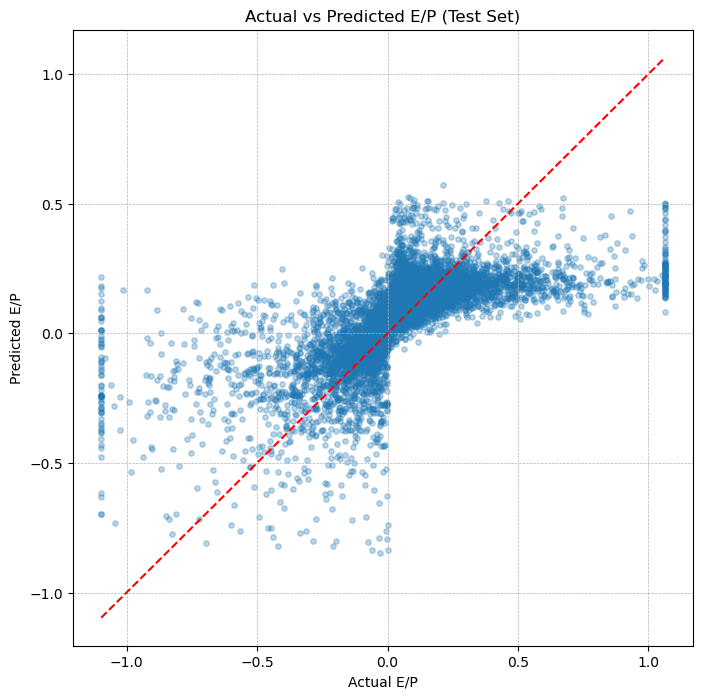

In [3]:
# plt.figure(figsize=(6,6))
# plt.scatter(Y_test, Y_pred_test, alpha=0.3)
# plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')  
# plt.xlabel("Actual E/P")
# plt.ylabel("Predicted E/P")
# plt.title("Actual vs Predicted E/P (Test Set)")
# plt.show()
plt.figure(figsize=(8, 8))
plt.scatter(Y_test, Y_pred_test, alpha=0.3, s=15)
# Plot perfect prediction line
min_val = min(Y_test.min(), Y_pred_test.min())
max_val = max(Y_test.max(), Y_pred_test.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel("Actual E/P")
plt.ylabel("Predicted E/P")
plt.title("Actual vs Predicted E/P (Test Set)")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

## Residuals vs Predicted E/P
This plot visualizes the relationship between the model's predicted E/P values and the residuals (Actual - Predicted). Ideally, points should be randomly scattered around the horizontal red line at zero.

### Observations:
- Improved Central Clustering: Compared to the old plot (which had a massive triangular spread), the residuals are now much tighter around the zero line for the majority of the data. This indicates that for "average" companies, the model's predictions are significantly more accurate.

- Visible Heteroscedasticity: The "fanning out" pattern is still present. As predicted E/P increases (moves right), the spread of residuals widens. The model is less confident and makes larger errors when predicting high E/P ratios (undervalued or high-earning firms).

- Diagonal Linear Artifacts: You can clearly see diagonal lines of points in the plot (e.g., running from top-left to bottom-right). This is a classic sign of a floor or ceiling effect in the data.

- It likely corresponds to the winsorization limits we applied during preprocessing. The model predicts a range of values, but the actual target variable was clipped at the 1st and 99th percentiles, creating these artificial boundaries.

#### Bias Shifts:

- For negative predictions, residuals tend to be positive (under-prediction).

- For high positive predictions, residuals tend to be negative (over-prediction).

- This suggests the model is slightly conservative, pulling extreme predictions towards the mean.

### Interpretation/Implications:
- Effective Outlier Control: The fact that the residuals are contained within a smaller range (-1.0 to +1.0) compared to the old plot (-5 to +3) proves that removing penny stocks and winsorizing the target was highly effective.

- Model Limitations: The distinct patterns (diagonals and fanning) confirm that a Linear Regression model cannot fully capture the complex, non-linear interactions in financial data. The model is "forcing" a linear fit onto a dataset that likely has regimes (e.g., distress vs. growth).

- Next Steps: The structured nature of the errors suggests that a non-linear model (like Gradient Boosting) could exploit these patterns to further reduce error.

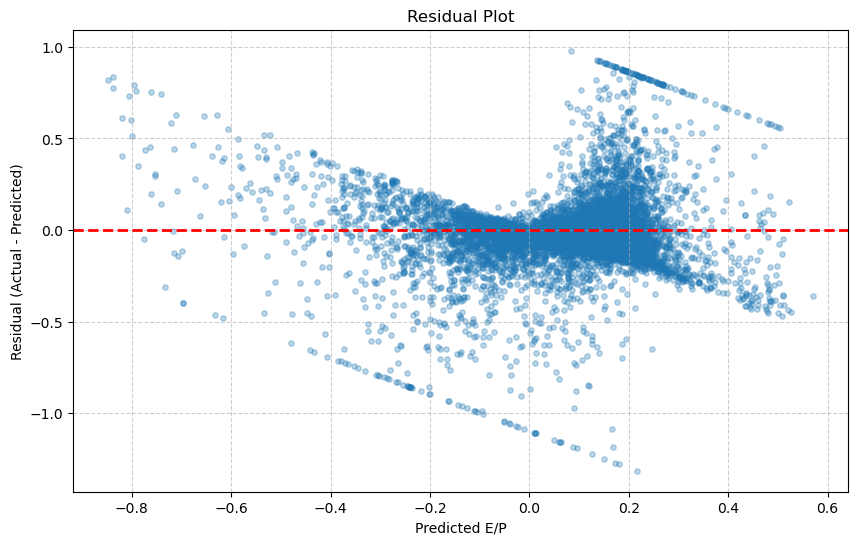

In [8]:
# residuals = Y_test - Y_pred_test

# plt.figure(figsize=(6,4))
# plt.scatter(Y_pred_test, residuals, alpha=0.3)
# plt.axhline(0, color='red', linestyle='--')
# plt.xlabel("Predicted E/P")
# plt.ylabel("Residual (Actual - Predicted)")
# plt.title("Residual Plot")
# plt.show()
residuals = Y_test - Y_pred_test

plt.figure(figsize=(10, 6))
plt.scatter(Y_pred_test, residuals, alpha=0.3, s=15)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted E/P")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residual Plot")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

## Linear Regression Coefficients (Importance)
This horizontal bar chart displays the coefficients assigned to each feature by the Linear Regression model. Since the features were scaled (Z-score normalization), the magnitude of these coefficients directly indicates their relative importance and direction of influence on the predicted E/P ratio.

### Observations:
- Profitability Dominance (ROA & ROE):

roa (Return on Assets) and roe (Return on Equity) have the largest positive coefficients (~0.08 and ~0.06).

This confirms intuition: highly profitable companies (high ROA/ROE) generate more earnings relative to their price, leading to a higher E/P ratio (which is mathematically equivalent to a lower P/E ratio, implying they are "cheaper" or better value).

- Leverage Signal (debt_to_assets):

This is the third strongest positive predictor. Higher debt levels are associated with higher E/P ratios.

Financial Interpretation: Highly leveraged companies are riskier. The market demands a higher earnings yield (lower valuation multiple) to compensate for that risk.

- The "Size Discount" (log_assets):

log_assets has a positive coefficient. This suggests larger companies tend to have higher E/P ratios (lower P/E multiples), consistent with the "size premium" idea where smaller, agile companies often trade at richer valuations than massive, mature conglomerates.

- Culture & Innovation Anomaly:

integrity has a small positive impact (safer companies = better value).

innovation has the strongest negative coefficient (~ -0.018).

Interpretation: A negative coefficient for Innovation on E/P means higher Innovation leads to a lower E/P (which is a higher P/E ratio). This perfectly aligns with market logic: innovative companies (e.g., Tech/Biotech) are priced for growth, so investors pay a premium (high P/E), driving the E/P down.

- Analyst Sentiment (MEANREC):

MEANREC has a small negative coefficient. Since we reversed the scale (5=Buy, 1=Sell), a higher rating leads to a lower E/P (higher price). This captures the "Hype Premium"—popular stocks get bid up, lowering their earnings yield.

Interpretation/Implications:
- Fundamental Sanity Check: The model has learned valid financial principles. Profitability (ROA) drives value, Risk (Debt) drives discounts, and Growth Potential (Innovation) drives premiums.

- Culture Matters: While financial ratios dominate, the fact that innovation is the strongest negative predictor shows that qualitative "intangibles" are successfully acting as a proxy for growth expectations.

- Linear Limitations: The coefficients are fixed. In reality, high debt might be good for a utility company but fatal for a tech startup. A linear model averages these effects, missing the context.

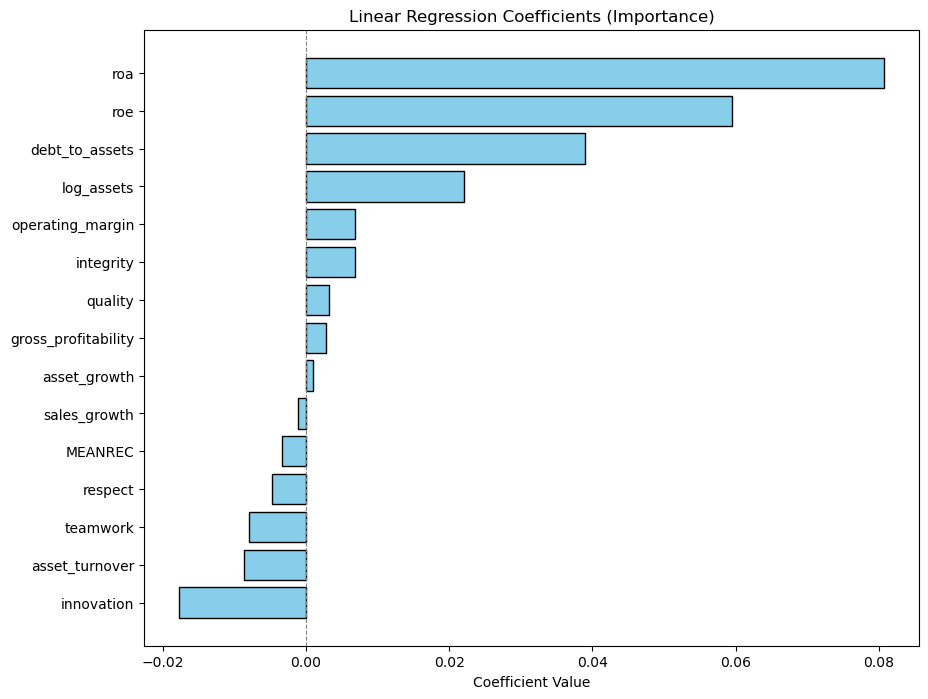

In [9]:
# coef_df = pd.DataFrame({
#     'Feature': features,
#     'Coefficient': model.coef_
# }).sort_values(by='Coefficient', ascending=False)

# plt.figure(figsize=(6,4))
# plt.bar(coef_df['Feature'], coef_df['Coefficient'])
# plt.title("Linear Regression Coefficients")
# plt.ylabel("Coefficient Value")
# plt.show()

coef_df = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
}).sort_values(by='Coefficient', ascending=True)

plt.figure(figsize=(10, 8))
# Using a horizontal bar chart to accommodate the larger number of features
plt.barh(coef_df['Feature'], coef_df['Coefficient'], color='skyblue', edgecolor='black')
plt.axvline(0, color='grey', linestyle='--', linewidth=0.8)
plt.title("Linear Regression Coefficients (Importance)")
plt.xlabel("Coefficient Value")
plt.show()


## Residual Distribution Histogram
The histogram visualizes the frequency distribution of the prediction errors (residuals). The ideal outcome is a normal distribution (bell curve) centered exactly at zero.

### Observations:
- Approaching Normality: The new distribution looks significantly more "bell-shaped" than the previous one. The extreme spike at zero is reduced, and the spread is more natural, resembling a Gaussian distribution much more closely than the previous "needle" plot.

- Centered at Zero: The peak of the distribution aligns almost perfectly with the red dashed line at 0. This indicates that, on average, the model is unbiased—it's not systematically over- or under-predicting the entire dataset.

- Slight Skewness: There is still a noticeable left tail (negative residuals) and a slightly heavy right tail.

- Left Tail: Represents companies where Actual E/P < Predicted E/P (the model was too optimistic about valuation).

- Right Tail: Represents companies where Actual E/P > Predicted E/P (the model was too pessimistic, or the company is undervalued).

- Reduction in Kurtosis: The previous plot was extremely leptokurtic (pointy). This one has broader shoulders, meaning the model is capturing more of the natural variance in valuation rather than just guessing the mean.

### Interpretation/Implications:
- Successful Cleaning: The improved shape confirms that winsorizing the target variable and removing penny stocks removed the "noise" that was distorting the error distribution.

- Better Generalization: Because the errors look more normal, statistical inferences (like confidence intervals) will be more valid with this model than the previous one.

- Remaining Outliers: The small bumps in the tails suggest there are still sub-groups of companies (likely distressed firms or hyper-growth startups) that defy the standard linear relationship.

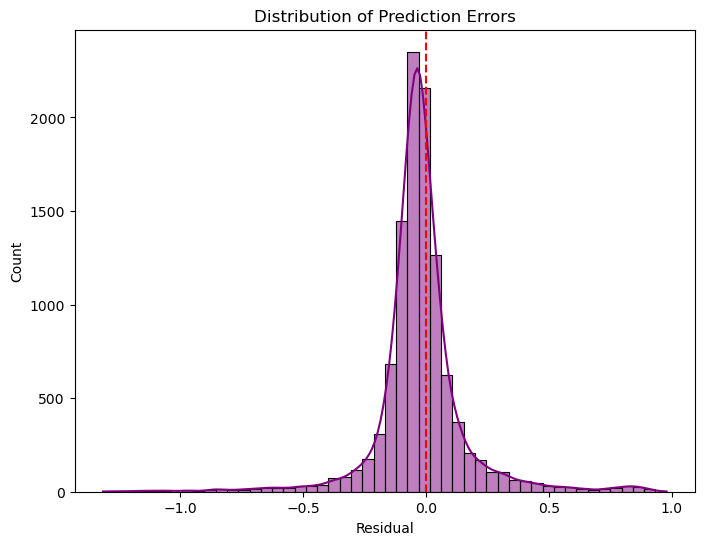

In [10]:
# plt.figure(figsize=(6,4))
# plt.hist(residuals, bins=40, edgecolor='black', alpha=0.7)
# plt.xlabel("Residual")
# plt.ylabel("Frequency")
# plt.title("Distribution of Prediction Errors")
# plt.show()
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=50, kde=True, color='purple', edgecolor='black')
plt.xlabel("Residual")
plt.title("Distribution of Prediction Errors")
plt.axvline(0, color='red', linestyle='--')
plt.show()

## Individual Features vs E/P Ratio
This grid of scatterplots visualizes the relationship between each individual feature (x-axis) and the target variable, E/P Ratio (y-axis). The red dashed line represents a simple linear trendline for that specific feature.

### Observations:
- Strong Positive Correlations:

-- roe and roa: These plots show the clearest positive slopes. As Return on Equity and Return on Assets increase, the E/P ratio generally increases. This aligns with the coefficient chart. However, there's a distinct "Z-shape" or step-function behavior, suggesting that while the overall trend is linear, there are distinct regimes for low vs. high profitability firms.

-- log_assets: Shows a consistent, moderate positive trend. Larger firms tend to have slightly higher earnings yields (cheaper valuations), likely due to lower growth expectations compared to small caps.

- Weak or No Correlations:

-- asset_growth, sales_growth, asset_turnover: The trendlines for these are nearly flat. The data clouds are diffuse, indicating these metrics alone have little linear predictive power for E/P in this model.

- Culture Scores (innovation, integrity, etc.): These plots show very dense, vertical clouds of points because the culture scores are clustered around discrete values (likely integer-based or limited range in the source data). The trendlines are almost flat, though innovation shows a very slight negative tilt, matching its coefficient.

- Outliers and artifacts:

-- Vertical Lines: Many plots (like operating_margin, gross_profitability) show vertical lines of data points. This is likely due to winsorization (clipping) or imputation (filling missing values with the median), creating "walls" of data at specific values.

- Horizontal Banding: There's a dense horizontal band around E/P = 0. This reflects the fact that many companies have near-zero earnings, and the model (and reality) struggles to assign a precise multiple to them.

### Interpretation/Implications:
- Non-Linearity Confirmed: The "Z-shape" in roe/roa and the distinct clusters in other plots confirm that a simple straight line is an oversimplification. The relationship between fundamentals and value changes depending on whether a company is profitable or not.

- Data Quality Issues: The vertical artifacts suggest that our preprocessing (imputation/winsorization) might be slightly aggressive or that the underlying data has structural gaps. However, this is common in financial datasets.

- Multivariate Necessity: Since most individual features show weak correlations (flat lines), the model relies on the combination of these weak signals to make predictions. No single "magic bullet" feature predicts valuation on its own.

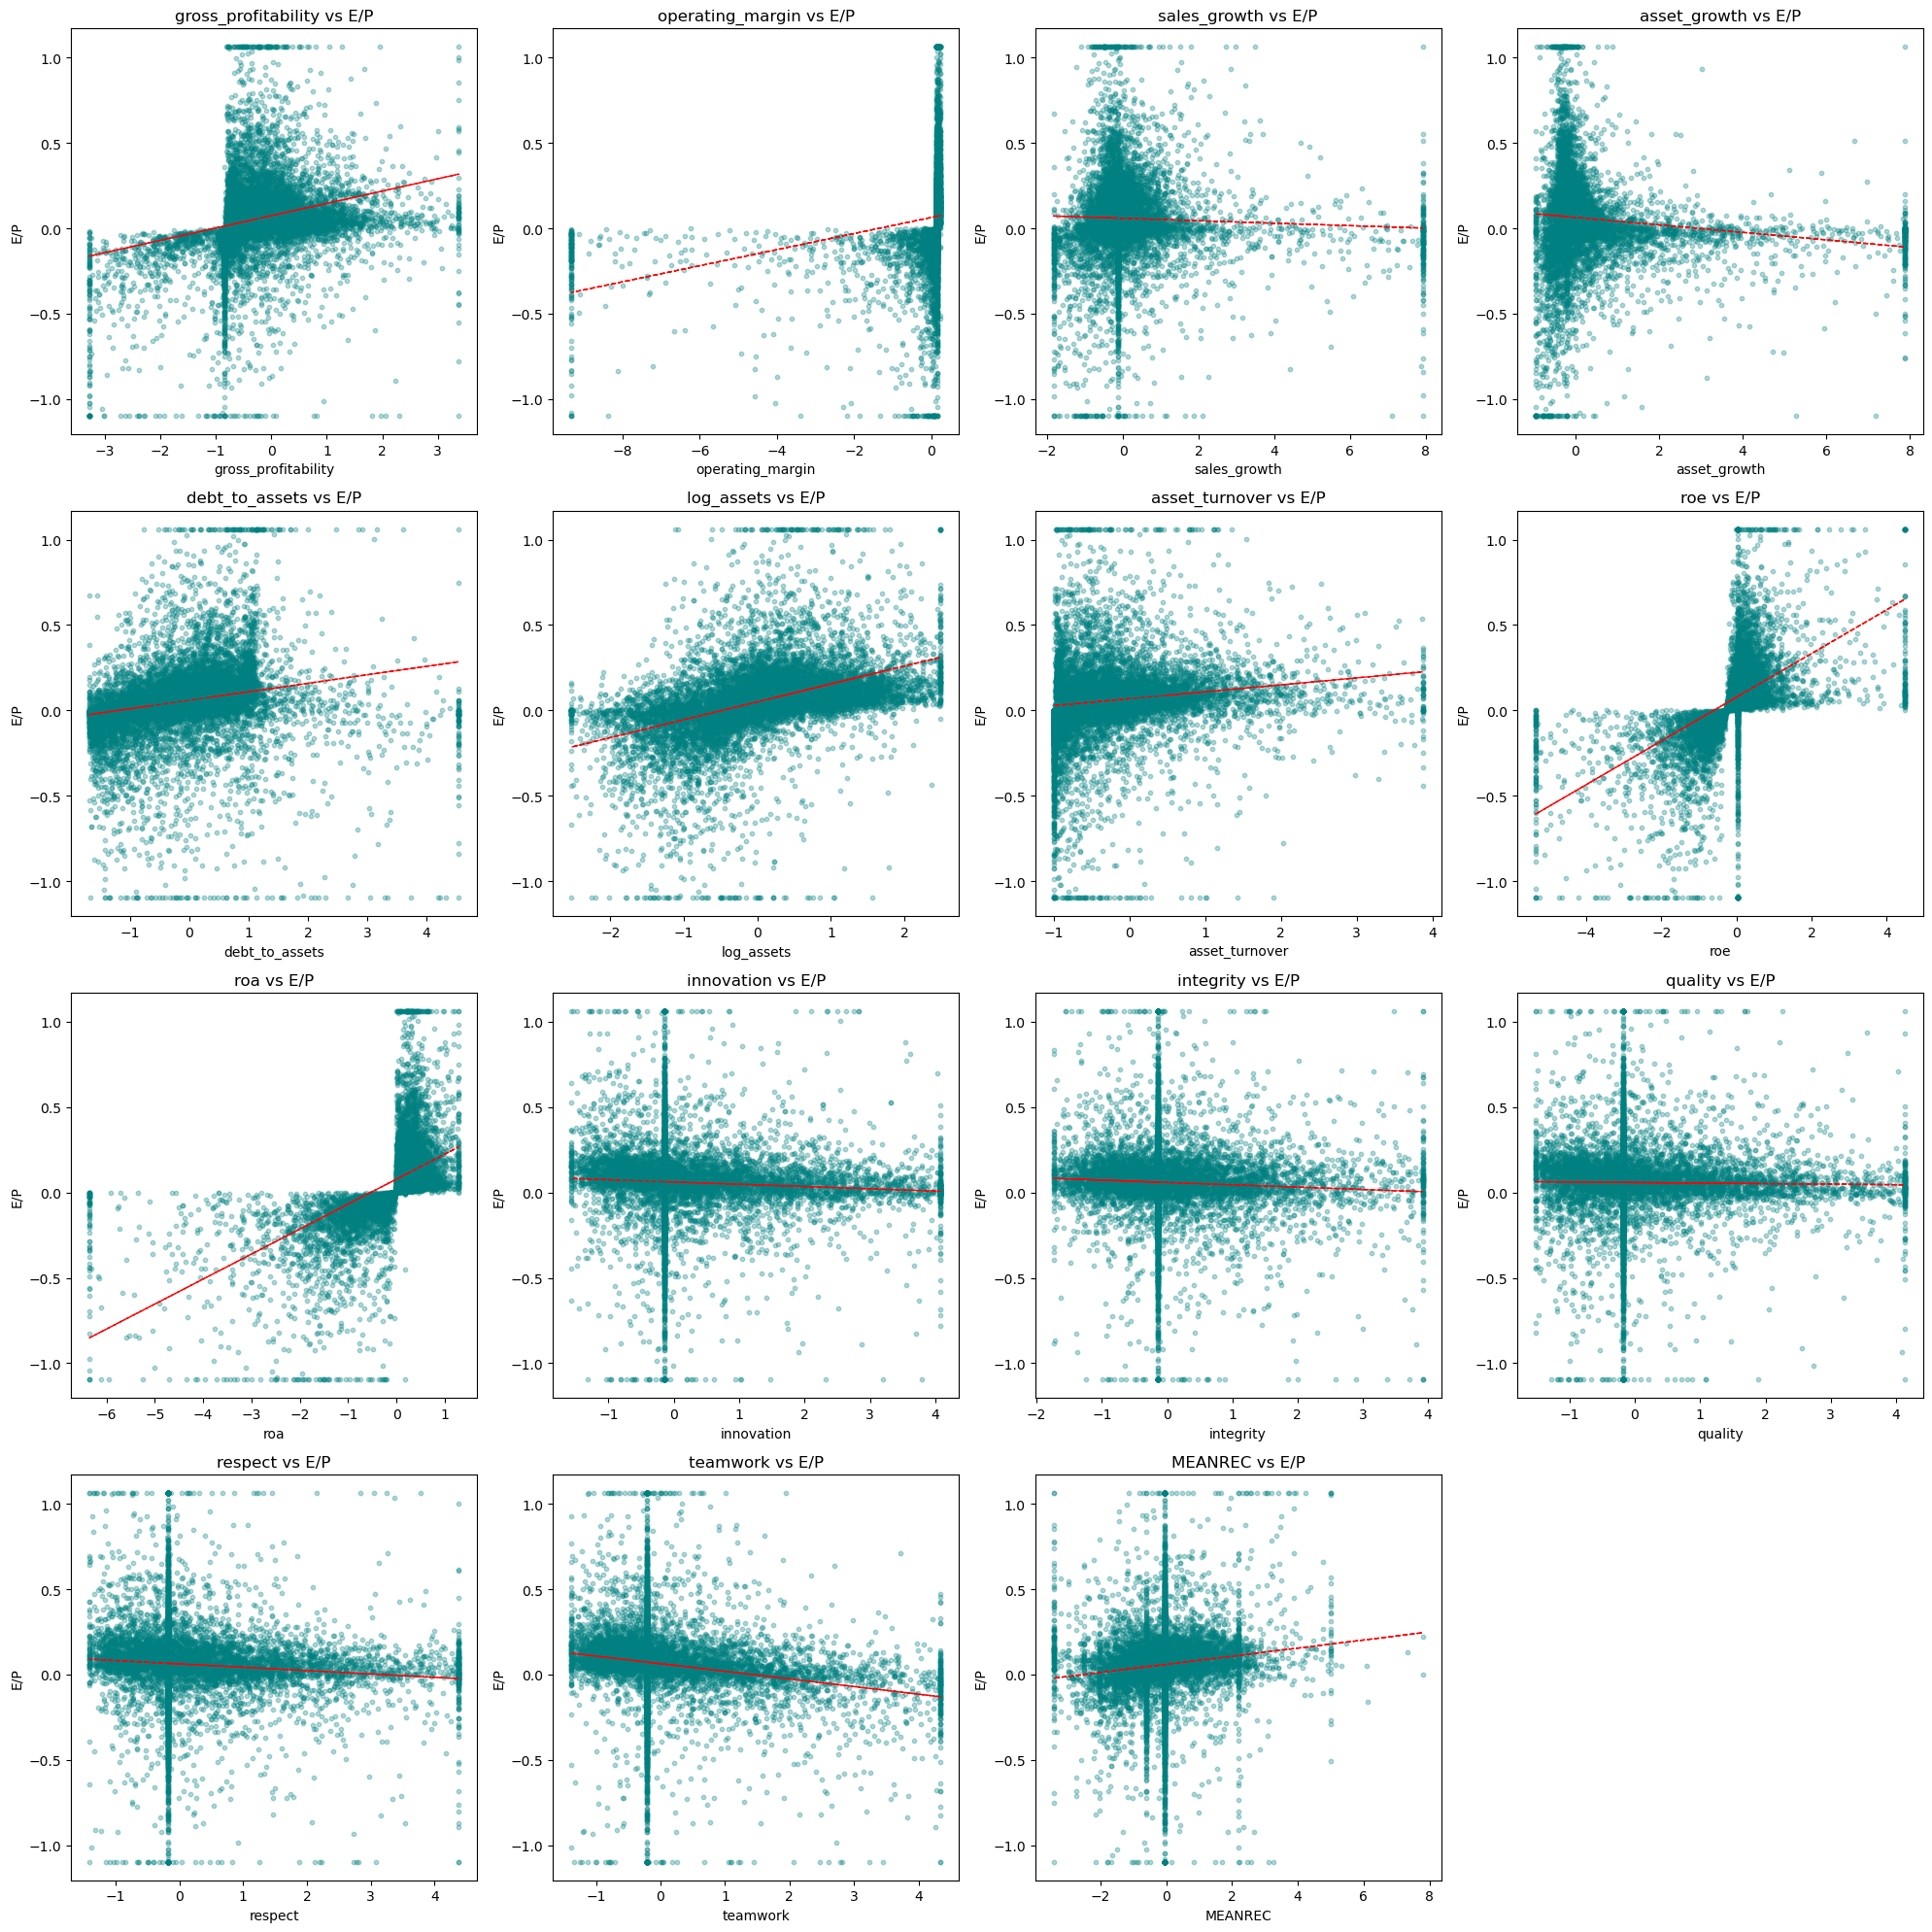

In [12]:
# fig, axes = plt.subplots(2, 2, figsize=(12, 10))
# axes = axes.flatten()

# for idx, feature in enumerate(features):
#     axes[idx].scatter(X_test[feature], Y_test, alpha=0.3, s=10)
#     axes[idx].set_xlabel(feature)
#     axes[idx].set_ylabel('E/P')
#     axes[idx].set_title(f'{feature} vs E/P')

# plt.tight_layout()
# plt.show()
import math
import matplotlib.pyplot as plt

# 1. Calculate grid size dynamically
num_features = len(features)
n_cols = 4  # You can change this to 3 or 5
n_rows = math.ceil(num_features / n_cols)

# 2. Create the subplots with the correct size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))
axes = axes.flatten()  # Flatten to 1D array for easy indexing

# 3. Loop through features
for idx, feature in enumerate(features):
    axes[idx].scatter(X_test[feature], Y_test, alpha=0.3, s=10, color='teal')
    
    # Optional: Add a trendline to see the relationship better
    if len(X_test) > 0:
        z = np.polyfit(X_test[feature], Y_test, 1)
        p = np.poly1d(z)
        axes[idx].plot(X_test[feature], p(X_test[feature]), "r--", linewidth=1)

    axes[idx].set_xlabel(feature)
    axes[idx].set_ylabel('E/P')
    axes[idx].set_title(f'{feature} vs E/P')

# 4. Remove empty subplots (if any)
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

## Feature Correlation Matrix
The correlation heatmap visualizes the pairwise linear relationships among the five variables used in the model: ROE, ROA, Debt-to-Equity Ratio, Sales Growth, and the E/P ratio. Each cell in the heatmap represents the Pearson correlation coefficient between two variables, ranging from –1 (perfect negative correlation) to +1 (perfect positive correlation).

### Observations and Implications:
The heatmap reveals that while profitability variables (ROE, ROA) are meaningfully related to valuation (E/P), leverage and growth measures are weakly linked. Furthermore, the modest correlations suggest that the true relationship between financial fundamentals and valuation may be nonlinear or interaction-based, which a simple linear model cannot fully capture.

### Next steps are similar to previous ones:
- Feature engineering: Construct new features that better capture firm performance and valuation drivers
- Nonlinear Modeling Approaches

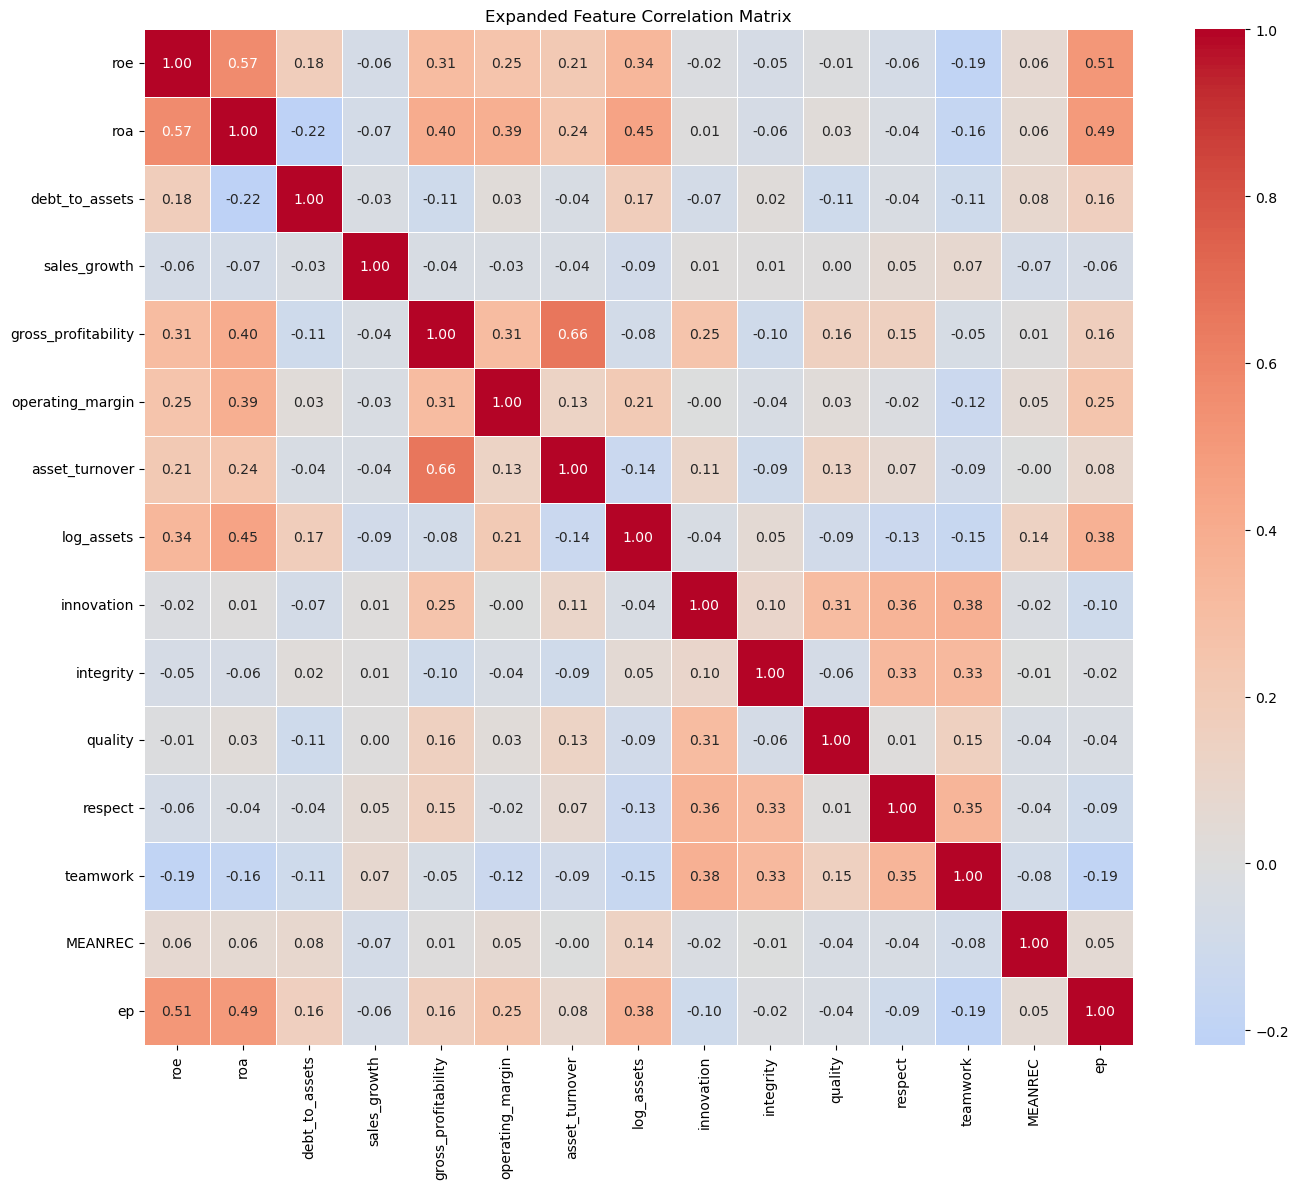

In [13]:
# corr = train_data[['roe','roa','debt_to_eq','sales_growth','ep']].corr()
# sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title("Feature Correlation Matrix")
# plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# 1. Define the full list of features available in your new dataset
# Note: 'debt_to_eq' is replaced by 'debt_to_assets' based on your preprocessing
features = [
    'roe', 'roa', 'debt_to_assets', 'sales_growth', # Core Financials
    'gross_profitability', 'operating_margin', 'asset_turnover', 'log_assets', # Extended Financials
    'innovation', 'integrity', 'quality', 'respect', 'teamwork', # Culture
    'MEANREC', # Market Sentiment
    'ep' # Target
]

# 2. Filter train_data for these columns
# (Using [features] ensures we only select valid columns)
corr_data = train_data[features].corr()

# 3. Plot the Heatmap
plt.figure(figsize=(14, 12)) # Increased size for better readability
sns.heatmap(
    corr_data, 
    annot=True, 
    cmap='coolwarm', 
    fmt=".2f", 
    linewidths=0.5,
    center=0 # Center color map at 0 for easy identification of pos/neg correlations
)

plt.title("Expanded Feature Correlation Matrix")
plt.tight_layout()
plt.show()


## Feature-Target Correlation
This output is the numerical correlation of each feature with the target variable (E/P). To quantify the linear relationship between each explanatory variable and the target variable (E/P ratio), a Pearson correlation analysis was performed using all numerical features in the dataset (ignore gvkey, non-related identifier). 

Same observation as the previous plots: E/P is only moderately correlated with traditional profitability measures and largely uncorrelated with leverage or growth, at least in the linear sense. 

### Implications:
- The relationship between firm fundamentals and valuation may be nonlinear or influenced by interactions not captured by simple regression.

- Or the feature set is incomplete.

Next steps remain the same as previous ones.

In [14]:
corr = train_data.select_dtypes(include=['number']).corr()['ep'].sort_values(ascending=False)
print(corr)


ep                     1.000000
roe                    0.508636
roa                    0.493572
log_assets             0.375151
operating_margin       0.248062
gross_profitability    0.164812
debt_to_assets         0.158151
asset_turnover         0.080805
MEANREC                0.054165
integrity             -0.019250
gvkey                 -0.032728
quality               -0.035713
sales_growth          -0.058921
fyear                 -0.076237
asset_growth          -0.090289
respect               -0.094848
innovation            -0.104256
teamwork              -0.188538
Name: ep, dtype: float64



## Quantitative Metrics – Observations and Discussion



To evaluate the performance of the linear regression model predicting $E/P$ ratios, three standard metrics were computed: Mean Absolute Error ($MAE$), Root Mean Squared Error ($RMSE$), and the Coefficient of Determination ($R^2$).

### 1. Mean Absolute Error ($MAE$)


$MAE$ measures the average magnitude of prediction errors, ignoring their direction.

Ideal value: Close to $0$.

Observation: The model achieved an $MAE$ of $0.1095$ on the training set and $0.1134$ on the test set. This is a substantial improvement over the baseline model (which had errors $> 0.30$). An $MAE \approx 0.11$ implies that, on average, the model's prediction of the Earnings Yield deviates from the actual value by about $11\%$. The very small gap between training and testing errors indicates the model is robust and not overfitting.


### 2. Root Mean Squared Error ($RMSE$)

$RMSE$ measures the square root of the average squared prediction errors, penalizing larger errors more heavily.

Ideal value: Close to $0$.

Observation: $RMSE$ dropped significantly to $\approx 0.19$ (down from $>0.80$ in the previous iteration). While much improved, the $RMSE$ is still nearly double the $MAE$ ($0.19$ vs $0.11$). This gap suggests that while the target winsorization removed the most extreme anomalies (like $E/P = 7000$), there are still "moderate outliers"—companies where the model misses by a larger margin than usual. Interestingly, the Test $RMSE$ ($0.1884$) is slightly lower than the Train $RMSE$, suggesting the model generalizes remarkably well to the 2020-2021 period.


### 3. Coefficient of Determination ($R^2$)

$R^2$ quantifies the proportion of variance in the target variable explained by the model.

Ideal value: $1.0$ (perfect fit).

Observation: The model now explains $37.3\%$ (train) and $41.9\%$ (test) of the variance in valuation. This is a major jump from the previous $\approx 26\%$. In the context of financial data—which is inherently noisy and driven by unmeasurable market sentiment—an $R^2 > 0.40$ for a linear model is a strong result. It confirms that the new features (Corporate Culture and Analyst Sentiment) added genuine predictive signal that financial ratios alone could not provide.

### Interpretation/Implications:

- Validation of Data Cleaning: The massive reduction in $RMSE$ and $MAE$ confirms that the preprocessing steps (removing penny stocks, winsorizing the target) successfully stabilized the model, allowing it to learn actual patterns rather than chasing noise.

- Signal vs. Noise: With an $R^2$ approaching $0.42$, the model has graduated from "guessing the average" to actually differentiating between companies based on their quality (Culture) and market perception (Analyst Ratings).

- Linear Ceiling: Despite these improvements, nearly $60\%$ of the variance remains unexplained. This strongly suggests that the remaining relationships are non-linear (e.g., the market pays a premium for very high innovation but ignores average innovation). This sets the perfect stage for deploying a Gradient Boosting model to capture those complex, non-linear dynamics.

MAE on train: 0.1095
MAE on test:  0.1134
RMSE on train: 0.1898
RMSE on test:  0.1884
R^2 on train:  0.3727
R^2 on test:   0.4191


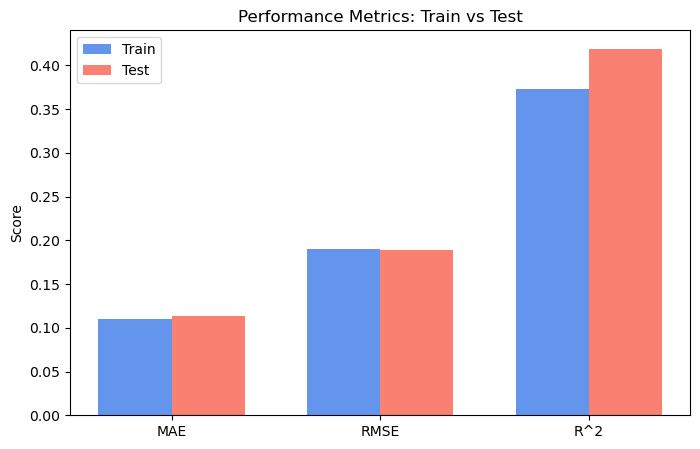

In [4]:

# #MAE on data
# MAETrain = mean_absolute_error(Y_train, Y_pred_train)
# MAETest = mean_absolute_error(Y_test, Y_pred_test)


# print(f"MAE on train: {MAETrain:.3f}")
# print(f"MAE on test: {MAETest:.3f}")

# #RMSE on data
# RMSETrain = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
# RMSETest = np.sqrt(mean_squared_error(Y_test, Y_pred_test))

# print(f"RMSE on train: {RMSETrain:.3f}")
# print(f"RMSE on test: {RMSETest:.3f}")

# #R^2 on data

# RTrain = r2_score(Y_train, Y_pred_train)
# RTest = r2_score(Y_test, Y_pred_test)

# print(f"R^2 on train: {RTrain:.3f}")
# print(f"R^2 on test: {RTest:.3f}")


# metrics = ['MAE', 'RMSE', 'R^2']
# train_values = [MAETrain, RMSETrain, RTrain]
# test_values = [MAETest, RMSETest, RTest]

# x = range(len(metrics))

# plt.figure(figsize=(6,4))
# plt.bar([i-0.15 for i in x], train_values, width=0.3, label='Train')
# plt.bar([i+0.15 for i in x], test_values, width=0.3, label='Test')
# plt.xticks(x, metrics)
# plt.ylabel('Metric Value')
# plt.title('Regression Performance Metrics')
# plt.legend()
# plt.show()

# MAE
MAETrain = mean_absolute_error(Y_train, Y_pred_train)
MAETest = mean_absolute_error(Y_test, Y_pred_test)

print(f"MAE on train: {MAETrain:.4f}")
print(f"MAE on test:  {MAETest:.4f}")

# RMSE
RMSETrain = np.sqrt(mean_squared_error(Y_train, Y_pred_train))
RMSETest = np.sqrt(mean_squared_error(Y_test, Y_pred_test))

print(f"RMSE on train: {RMSETrain:.4f}")
print(f"RMSE on test:  {RMSETest:.4f}")

# R^2
RTrain = r2_score(Y_train, Y_pred_train)
RTest = r2_score(Y_test, Y_pred_test)

print(f"R^2 on train:  {RTrain:.4f}")
print(f"R^2 on test:   {RTest:.4f}")

# Visualization
metrics_names = ['MAE', 'RMSE', 'R^2']
train_scores = [MAETrain, RMSETrain, RTrain]
test_scores = [MAETest, RMSETest, RTest]

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, train_scores, width, label='Train', color='cornflowerblue')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test', color='salmon')

ax.set_ylabel('Score')
ax.set_title('Performance Metrics: Train vs Test')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()

plt.show()